In [1]:
import joblib
import pandas as pd
import numpy as np
from tqdm import tqdm
import itertools
from sklearn.feature_extraction.text import CountVectorizer
from scipy.stats import pearsonr

%run procedural_stop_words.py

from plotnine import ggplot, aes, geoms, theme, ggtitle, ylim, xlim, ylab
from plotnine import element_blank, element_line, element_text, scales, annotate,facet_wrap

from scipy.spatial.distance import cosine

In [2]:
all_df = pd.read_csv('Results/All_speeches_labelled.csv')
all_df = all_df.loc[all_df.party_y != 'I']

combinations = []
for year in range(1983,2017):
    for topic in all_df.dynamic_label.unique():
        combinations.append((year,topic))

In [7]:
def make_DTM(sub,binary=True):
    features = sub.groupby('speaker',as_index=False).party_y.first()
    
    # document term matrix
    vectorizer = CountVectorizer(min_df=5,binary=binary,stop_words=procedural_stop_words)
    DTM = vectorizer.fit_transform(sub.speech_processed)
    DTM = pd.DataFrame(DTM.toarray())

    # associate DTM with speaker and get frequency by speaker
    DTM['speaker'] = list(sub['speaker'])
    
    DTM = (DTM
           .groupby('speaker',as_index=False)
           .sum()
           .merge(features,on='speaker',how='left')
           .drop('speaker',1)
          )

    # assign terms to DTM
    terms = vectorizer.get_feature_names()
    DTM.columns = terms + ['party_y']
    
    return DTM

def chi_sq(x):
    numer = ((x['R']*x['Dn']) - (x['D']*x['Rn']))**2
    denom = (x['R'] + x['D']) * (x['R'] + x['Rn']) * (x['D'] + x['Dn']) * (x['Dn'] + x['Rn'])
    return numer/denom

def chiSq_df(dtm,permute=False):
    if permute:
        dtm.party_y = np.random.permutation(dtm.party_y.values)
        
    term_frequencies = dtm.groupby('party_y').sum().T  # term frequency by party
    total_frequencies = term_frequencies.sum()  # total frequencies

    # set up for chi-square test
    term_frequencies['Dn'] =  total_frequencies['D'] - term_frequencies['D'] 
    term_frequencies['Rn'] = total_frequencies['R'] - term_frequencies['R']
    term_frequencies['chi2'] = term_frequencies.apply(chi_sq,1)

    term_frequencies['terms'] = dtm.columns[:-1]
    
    return term_frequencies

def perform_correlations(dtm,permute=False):
    party_ID = [-1 if party == 'D' else 1 for party in dtm.party_y]
    dtm = dtm.drop('party_y',1)
    
    dtm_normed = np.apply_along_axis(lambda x: (x - np.mean(x))/np.std(x),0,dtm.to_numpy())
    
    # perform correlation analysis
    if permute:
        party_ID = np.random.permutation(party_ID)
        
    corrs = np.apply_along_axis(lambda x: pearsonr(x,party_ID)[0],0,dtm_normed)
    
    df = pd.DataFrame({
            "term":dtm.columns,
            "correlation":corrs,
            'freq':dtm.sum(0)
        }).dropna()
    
    return df

In [51]:
np.random.permutation([1,2,3,4])

array([4, 1, 2, 3])

In [32]:
def run_similarity(year,topic,binary=True):
    sub_df = all_df.loc[(all_df.year_y == year) & (all_df.dynamic_label == topic)]

    if len(sub_df) > 0:

        DTM = make_DTM(sub_df,binary=binary) # Make DTM
        term_df = chiSq_df(DTM) # Make Chi_square frequency table

        pre_drop_terms = DTM.columns[:-1] # record keeping
        
        # remove low value chi square terms
        term_df['chi2'] = term_df.loc[term_df.chi2 > 0]
        drop_cols = list(term_df.loc[term_df.chi2 <= 0,'terms'].values)
        DTM = DTM.drop(drop_cols,1)

        corr_df = perform_correlations(DTM) # make correlation DF
        
        # calculate metrics
        corr_df['weighted'] = corr_df['correlation']*corr_df['freq']
        partisanship = corr_df['weighted'].sum()/corr_df['freq'].sum()
        polarization = corr_df['weighted'].abs().sum()/corr_df['freq'].sum()
        distance = cosine(term_df['D'],term_df['R'])
        
        return {"results":{'distance':distance,
                    'polarization':polarization,
                    'partisanship':partisanship,
                    "pre_termlength":len(pre_drop_terms),
                    'post_termlength':len(corr_df)},
                'correlations':corr_df,
                'topic':topic,
                'year':year
               }

# Run analysis

In [35]:
Binary_Results = []
NonBinary_Results = []
pbar = tqdm(combinations)
for combination in pbar:
    pbar.set_description("%s %s"%combination)
    
    year,topic = combination
    f = run_similarity(year,topic,binary=True)
    f2 = run_similarity(year,topic,binary=False)
    if f:
        Binary_Results.append(f)
        NonBinary_Results.append(f2)


2007 veterans:  72%|███████▏  | 1532/2142 [08:17<04:33,  2.23it/s]           <ipython-input-31-b505531a1d71>:27: RuntimeWarning: overflow encountered in long_scalars


2016 healthcare: 100%|██████████| 2142/2142 [11:06<00:00,  3.21it/s]               


In [36]:
Binary_DF = []

for b in Binary_Results:
    df = b['results']
    df['topic'] = b['topic']
    df['year'] = b['year']
    Binary_DF.append(df)
    
Binary_DF = pd.DataFrame(Binary_DF)

Non_Binary_DF = []

for b in NonBinary_Results:
    df = b['results']
    df['topic'] = b['topic']
    df['year'] = b['year']
    Non_Binary_DF.append(df)
    
Non_Binary_DF = pd.DataFrame(Non_Binary_DF)

<AxesSubplot:xlabel='year'>

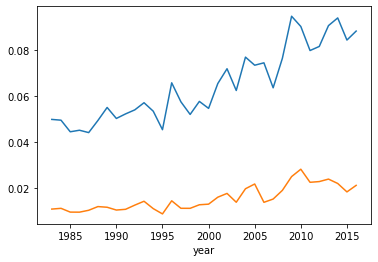

In [37]:
Binary_DF.groupby('year').distance.mean().plot(x='year',y='distance')
Non_Binary_DF.groupby('year').distance.mean().plot(x='year',y='distance')

<AxesSubplot:xlabel='year'>

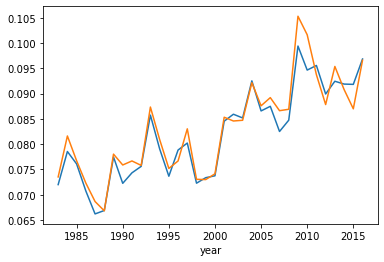

In [38]:
Binary_DF.groupby('year').polarization.mean().plot(x='year',y='polarization')
Non_Binary_DF.groupby('year').polarization.mean().plot(x='year',y='polarization')

<AxesSubplot:xlabel='year'>

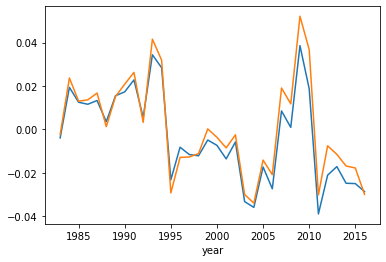

In [39]:
Binary_DF.groupby('year').partisanship.mean().plot(x='year',y='partisanship')
Non_Binary_DF.groupby('year').partisanship.mean().plot(x='year',y='partisanship')

In [41]:
# with open('Results/Frame_results.pkl', 'wb') as File:
#     joblib.dump(Binary_Results,File)

with open('Results/Frame_results.pkl','rb') as File:
    Binary_Results = joblib.load(File)

In [4]:
def run_similarity_perm(year,topic,binary=True,perms=200):
    sub_df = all_df.loc[(all_df.year_y == year) & (all_df.dynamic_label == topic)]
    if len(sub_df) > 0:
        
        # get terms maintained from true results
        true_corrs = [b['correlations'] for b in Binary_Results 
                   if b['topic'] == topic and b['year'] == year]

        keep_terms = true_corrs[0].term.values
        
        DTM = make_DTM(sub_df,binary=binary) # Make DTM
        pre_drop_terms = DTM.columns[:-1] # record keeping
        drop_cols = [i for i in pre_drop_terms if i not in keep_terms]
        DTM = DTM.drop(drop_cols,1)
        
        Nulls = []
        for perm in range(perms):
            term_df = chiSq_df(DTM,permute=True) # Make Chi_square frequency table
            # remove low value chi square terms
            term_df['chi2'] = term_df.loc[-term_df.terms.isin(drop_cols)]

            corr_df = perform_correlations(DTM,permute=True) # make correlation DF

            # calculate metrics
            corr_df['weighted'] = corr_df['correlation']*corr_df['freq']
            partisanship = corr_df['weighted'].sum()/corr_df['freq'].sum()
            polarization = corr_df['weighted'].abs().sum()/corr_df['freq'].sum()
            distance = cosine(term_df['D'],term_df['R'])

            Nulls.append({'distance':distance,
                        'polarization':polarization,
                        'partisanship':partisanship,
                        "pre_termlength":len(pre_drop_terms),
                        'post_termlength':len(corr_df),
                        'topic':topic,
                        'year':year,
                        'iter':perm})
        return Nulls

In [8]:
Null_Results = []
pbar = tqdm(combinations)
for combination in pbar:
    pbar.set_description("%s %s"%combination)
    
    year,topic = combination
    f = run_similarity_perm(year,topic,binary=True)
    if type(f) == pd.core.frame.DataFrame:
        Null_Results.append(f)



1983 procedural:   0%|          | 0/2142 [00:24<?, ?it/s]


KeyboardInterrupt: 